In [1]:
import jax
import jax.numpy as jnp
import inspeqtor as sq
import pathlib
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import sympy as sp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.axes import Axes
import scienceplots


# Helper functions and constants

In [2]:
model_names = ["MAEF", "MSEE"]
metric_names = ["MAEF", "MSEE"]
target_unitary = sq.constant.SX


def predict_AGF(
    model: sq.model.BasicBlackBox,
    model_params: sq.model.VariableDict,
    pulse_sequence: sq.pulse.JaxBasedPulseSequence,
    pulse_params: sq.pulse.ParametersDictType,
    target_unitary: jnp.ndarray,
    unitaries_opt: jnp.ndarray,
):
    Wo_params = model.apply(
        model_params,
        jnp.expand_dims(
            sq.pulse.list_of_params_to_array(
                pulse_params, pulse_sequence.get_parameter_names()
            ),
            0,
        ),
        training=False,
    )

    # Calculate the predicted expectation values using model
    predicted_expvals = sq.model.get_predict_expectation_value(
        Wo_params,
        unitaries_opt[-2:-1],
        sq.utils.predefined.default_expectation_values_order,
    )

    noisy_prediction = sq.model.direct_AFG_estimation(
        sq.model.direct_AFG_estimation_coefficients(target_unitary),
        predicted_expvals.flatten(),
    )

    return noisy_prediction, {"predicted_expvals": predicted_expvals}


def plot_benchmark_result(model_data, theta_name: str, y_limit: tuple[float, float], font_size):
    result_df = model_data[theta_name]["result_df"]

    # Calculate the experimental AGF
    rows = []
    NUM_REPEATS = 100
    for i in range(NUM_REPEATS):
        result_df_slice = result_df[result_df["repeated_idx"] == i]

        formatted_expvals = []

        for row, exp in result_df_slice.iterrows():
            formatted_expvals.append(
                sq.data.ExpectationValue(
                    initial_state=exp["initial_state"],
                    observable=exp["observable"],
                    expectation_value=exp["expectation_value"],
                )
            )

        temp_expvals: list[float] = []
        for idx, exp in enumerate(sq.constant.default_expectation_values_order):
            temp_expvals.append(
                result_df_slice[
                    (result_df_slice["observable"] == exp.observable)
                    & (result_df_slice["initial_state"] == exp.initial_state)
                ]["expectation_value"].values[0]
            )

        reconstructed_superop = sq.physics.choi2superop(
            sq.physics.forest_process_tomography(formatted_expvals)
        )
        avg_gate_fidelity = sq.physics.avg_gate_fidelity_from_superop(
            reconstructed_superop, sq.physics.to_superop(jnp.array(target_unitary))
        )

        coefficients = sq.model.direct_AFG_estimation_coefficients(
            jnp.array(target_unitary)
        )
        direct_avg_gate_fidelity = sq.model.direct_AFG_estimation(
            coefficients, jnp.array(temp_expvals)
        )

        rows.append(
            {
                "repeated_idx": i,
                "avg_gate_fidelity": float(avg_gate_fidelity),
                "direct_avg_gate_fidelity": direct_avg_gate_fidelity,
                "submitted_at": result_df_slice["submitted_at"].min(),
                "running": result_df_slice["running"].min(),
                "finished": result_df_slice["finished"].max(),
            }
        )

    avg_gate_fidelity_df = pd.DataFrame(rows)
    # Make the "submit_at" column datetime
    avg_gate_fidelity_df["submitted_at"] = pd.to_datetime(
        avg_gate_fidelity_df["submitted_at"]
    )

    # Make the "running" column datetime
    avg_gate_fidelity_df["running"] = pd.to_datetime(avg_gate_fidelity_df["running"])

    # Make the "finished" column datetime
    avg_gate_fidelity_df["finished"] = pd.to_datetime(avg_gate_fidelity_df["finished"])

    # Create absolute time difference column
    avg_gate_fidelity_df["time_diff"] = (
        avg_gate_fidelity_df["running"] - avg_gate_fidelity_df["running"].min()
    ).dt.total_seconds() / 60

    # The left plot going to be scatter plot of the experimental fidelities
    # The right plot going to be the histogram of the experimental fidelities
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[3, 1])

    # Plot the scatter plot of the experimental fidelities
    s = sns.scatterplot(
        x="time_diff",
        y="avg_gate_fidelity",
        data=avg_gate_fidelity_df,
        ax=axes[0],
        color="#cbd5e1",
        label="Experiment",
        legend=False
    )

    # set the font size for the x-axis label
    s.set_xlabel("Time since first running (minutes)", fontsize=font_size)
    # set the font size for the y-axis label
    s.set_ylabel("Average gate fidelity", fontsize=font_size)
    # set the font size for the legend
    # set the font size for x-axis tick labels
    axes[0].tick_params(axis="x", labelsize=font_size)
    # set the font size for y-axis tick labels
    axes[0].tick_params(axis="y", labelsize=font_size)

    # Mean of the experimental fidelities
    mean = avg_gate_fidelity_df["avg_gate_fidelity"].mean()
    std = avg_gate_fidelity_df["avg_gate_fidelity"].std()
    axes[0].axhline(
        y=mean,
        color="#cbd5e1",
        linestyle="--",
    )

    print(f"Experimental AGF of theta predicted by {theta_name}")
    print(f"Mean: {mean}, Std: {std}")

    # Plot the histogram of the experimental fidelities with avg_gate_fidelity being the y-axis and shared x-axis with the scatter plot
    s = sns.histplot(
        y="avg_gate_fidelity",
        data=avg_gate_fidelity_df,
        bins=10,
        kde=True,
        color="#cbd5e1",
        label="Experiment",
        element="step",
        ax=axes[1],
    )

    # set the font size for the x-axis label
    s.set_xlabel("Counts", fontsize=font_size)
    # s.legend(fontsize=font_size, loc="lower left")
    # set the font size for the x tick labels
    axes[1].tick_params(axis="x", labelsize=font_size)

    # Mean of the experimental fidelities
    axes[1].axhline(
        y=mean,
        color="#cbd5e1",
        linestyle="--",
    )

    # Set limit for the y-axis
    axes[0].set_ylim(y_limit)

    axes[0].set_ylabel("Average gate fidelity")

    if theta_name == "MAEF":
        _model_name = r"$\mathbf{\Theta}_{\mathrm{AE[F]}}$"
    else:
        _model_name = r"$\mathbf{\Theta}_{\mathrm{MSE[E]}}$"
    # fig.suptitle(f"Control opitmized using {_model_name} model", fontsize=20)
    # fig.suptitle(f"{_model_name}", fontsize=20)

    # remove gap between the plots
    fig.subplots_adjust(wspace=0)
    return fig, axes


def plot_prediction_and_error_bar(
    axes: list[Axes], model_name: str, theta_name: str, model_data, fontsize
):
    for idx, ax in enumerate(axes):
        noisy_prediction = model_data[model_name]["prediction"][theta_name]
        color = model_data[model_name]["color"]

        ax.axhline(
            y=noisy_prediction,
            color=color,
            linestyle="--",
            label=f"{model_data[model_name]['latex']}",
        )

        prediction_bound_value = model_data[model_name]["history"][-1]["MAEF"]

        x_lim = ax.get_xlim()

        ax.fill_between(
            jnp.linspace(*axes[0].get_xlim(), num=100),
            noisy_prediction - prediction_bound_value,
            noisy_prediction + prediction_bound_value,
            color=color,
            alpha=0.1,
        )

        ax.set_xlim(x_lim)


def plot_model_performance(
    ax1: Axes,
    model_name: str,
    model_data,
    data_variance: float,
    fontsize=18,
):
    # fig, ax1 = plt.subplots(1, 1, figsize=figsize)

    MAEF_loss_text = r"$\mathcal{L}_{\mathrm{AE[F]}}$"
    MSEE_loss_text = r"$\sqrt{\frac{3}{4} \mathcal{L}_{\mathrm{MSE[E]}}}$"

    hist_df = pd.DataFrame(model_data[model_name]["history"])
    color = model_data[model_name]["color"]

    # Twin plot for MAEF and MSEE each have train and test loss
    train_MAEF = hist_df.query("loop == 'train'")["MAEF"].values
    step = hist_df.query("loop == 'train'")["step"]
    ax1.plot(
        step,
        train_MAEF,
        color="gray",
        alpha=0.25,
    )

    test_MAEF = hist_df.query("loop == 'test'")["MAEF"].values
    step = hist_df.query("loop == 'test'")["step"]
    ax1.plot(step, test_MAEF, label=MAEF_loss_text, color=color)

    # Annotate MAEF
    ax1.annotate(
        MAEF_loss_text,
        xy=(step.iloc[-1], test_MAEF[-1]),
        xytext=(-50, 10),
        textcoords="offset points",
        ha="center",
        fontsize=fontsize,
    )

    # ax1.set_xlabel("Train iteration", fontsize=fontsize)

    train_MSEE = hist_df.query("loop == 'train'")["MSEE"].values
    train_MSEE = jnp.sqrt(0.75 * train_MSEE)
    step = hist_df.query("loop == 'train'")["step"]
    ax1.plot(
        step,
        train_MSEE,
        color="gray",
        alpha=0.25,
    )

    test_MSEE = hist_df.query("loop == 'test'")["MSEE"].values
    test_MSEE = jnp.sqrt(0.75 * test_MSEE)
    step = hist_df.query("loop == 'test'")["step"]

    ax1.plot(step, test_MSEE, label=MSEE_loss_text, color=color)

    ax1.annotate(
        MSEE_loss_text,
        xy=(step.iloc[-1], jnp.sqrt(0.75 * data_variance)),
        xytext=(-50, 10),  # if model_name == "MAEF" else -20
        textcoords="offset points",
        fontsize=fontsize,
        ha="center",
    )  # Optional: center the text horizontally

    # Plot the data variance
    ax1.axhline(
        jnp.sqrt(0.75 * data_variance),
        color="gray",
        linestyle="--",
        label="Data variance",
    )

    # Annotate the model
    ax1.annotate(
        model_data[model_name]["latex"],
        xy=(step.iloc[-1], 0.1),
        xytext=(-10, 30),
        textcoords="offset points",
        fontsize=fontsize,
        ha="center",
    )  # Optional: center the text horizontally

    # Log scale for the loss
    ax1.set_yscale("log")
    ax1.set_ylim(8e-4, 0)

    # Set font size for the labels
    for label in ax1.get_xticklabels():
        label.set_fontsize(fontsize)
    for label in ax1.get_yticklabels():
        label.set_fontsize(fontsize)


def plot_model_performance_v2(
    ax1: Axes,
    model_name: str,
    model_data,
    data_variance: float,
    fontsize=18,
):
    # Define text for loss functions
    MAEF_loss_text = r"$\mathcal{L}_{\mathrm{AE[F]}}$"
    MSEE_loss_text = r"$\mathcal{L}_{\mathrm{MSE[E]}}$"

    hist_df = pd.DataFrame(model_data[model_name]["history"])
    color = model_data[model_name]["color"]

    # Main plot for MSEE
    train_MSEE = hist_df.query("loop == 'train'")["MSEE"].values
    # train_MSEE = jnp.sqrt(0.75 * train_MSEE)
    step_train = hist_df.query("loop == 'train'")["step"]
    ax1.plot(
        step_train,
        train_MSEE,
        color="gray",
        alpha=0.25,
    )

    test_MSEE = hist_df.query("loop == 'test'")["MSEE"].values
    # test_MSEE = jnp.sqrt(0.75 * test_MSEE)
    step_test = hist_df.query("loop == 'test'")["step"]

    # Plot test MSEE with label directly using LaTeX
    ax1.plot(step_test, test_MSEE, label=MSEE_loss_text, color=color)

    # Plot data variance on main plot with label
    ax1.axhline(
        # jnp.sqrt(0.75 * data_variance),
        data_variance,
        color="gray",
        linestyle="--",
        # label="Data variance",
    )

    # Add model name to main plot
    bbox_props = {
        "boxstyle": "round,pad=0.25",
        "facecolor": "white",
        "alpha": 0.8,
        "edgecolor": "lightgray",
    }
    ax1.text(
        0.15,
        0.80,
        model_data[model_name]["latex"],
        transform=ax1.transAxes,
        fontsize=fontsize,
        ha="left",
        va="bottom",
        bbox=bbox_props,
    )

    # Log scale for the main plot
    ax1.set_yscale("log")
    # ax1.set_ylim(8e-4, 0)

    # Add legend to main plot
    ax1.legend(fontsize=fontsize - 2, loc="lower right")

    # Create inset axes for MAEF
    inset_ax = ax1.inset_axes(
        [0.55, 0.55, 0.4, 0.4]
    )  # [x, y, width, height] in relative coordinates

    # Inset plot for MAEF
    train_MAEF = hist_df.query("loop == 'train'")["MAEF"].values
    inset_ax.plot(
        step_train,
        train_MAEF,
        color="gray",
        alpha=0.25,
    )

    test_MAEF = hist_df.query("loop == 'test'")["MAEF"].values
    # Plot test MAEF with label
    inset_ax.plot(step_test, test_MAEF, label=MAEF_loss_text, color=color)

    # Set log scale for inset plot
    inset_ax.set_yscale("log")

    # Style the inset plot
    # inset_ax.set_title(MAEF_loss_text, fontsize=fontsize-2)
    inset_ax.tick_params(labelsize=fontsize - 4)
    inset_ax.legend(fontsize=fontsize - 4, loc="upper right")

    # Set font size for the labels on main plot
    for label in ax1.get_xticklabels():
        label.set_fontsize(fontsize)
    for label in ax1.get_yticklabels():
        label.set_fontsize(fontsize)


def plot_model_performance_v3(
    ax1: Axes,
    model_name: str,
    model_data,
    data_variance: float,
    fontsize=18,
    x_ticklabels: bool = True,
):
    # Define text for loss functions
    MAEF_loss_text = r"$\mathcal{L}_{\mathrm{AE[F]}}$"
    MSEE_loss_text = r"$\mathcal{L}_{\mathrm{MSE[E]}}$"

    loss_latex = {
        "MAEF": MAEF_loss_text,
        "MSEE": MSEE_loss_text
    }

    main_loss = "MAEF" if model_name == "MAEF" else "MSEE"
    sub_loss = "MAEF" if model_name == "MSEE" else "MSEE"


    hist_df = pd.DataFrame(model_data[main_loss]["history"])
    color = model_data[model_name]["color"]

    train_main = hist_df.query("loop == 'train'")[main_loss].values
    step_train = hist_df.query("loop == 'train'")["step"]

    ax1.plot(
        step_train,
        train_main,
        color="gray",
        alpha=0.25,
    )

    test_main = hist_df.query("loop == 'test'")[main_loss].values
    step_test = hist_df.query("loop == 'test'")["step"]

    ax1.plot(step_test, test_main, label=loss_latex[main_loss], color=color)

    if main_loss == "MSEE":
        ax1.axhline(
            # jnp.sqrt(0.75 * data_variance),
            data_variance,
            color="gray",
            linestyle="--",
            # label="Data variance",
        )

    # Add model name to main plot
    bbox_props = {
        "boxstyle": "round,pad=0.25",
        "facecolor": "white",
        "alpha": 0.8,
        "edgecolor": "lightgray",
    }
    ax1.text(
        0.15,
        0.80,
        model_data[model_name]["latex"],
        transform=ax1.transAxes,
        fontsize=fontsize,
        ha="left",
        va="bottom",
        bbox=bbox_props,
    )

    # Log scale for the main plot
    ax1.set_yscale("log")
    # ax1.set_ylim(8e-4, 0)

    # Add legend to main plot
    ax1.legend(fontsize=fontsize - 2, loc="lower right")

    if not x_ticklabels:
        ax1.set_xticklabels([])

    # Create inset axes for MAEF
    inset_ax = ax1.inset_axes(
        [0.55, 0.55, 0.4, 0.4]
    )  # [x, y, width, height] in relative coordinates

    # Inset plot for MAEF
    sub_train = hist_df.query("loop == 'train'")[sub_loss].values
    inset_ax.plot(
        step_train,
        sub_train,
        color="gray",
        alpha=0.25,
    )

    sub_test = hist_df.query("loop == 'test'")[sub_loss].values
    # Plot test MAEF with label
    inset_ax.plot(step_test, sub_test, label=loss_latex[sub_loss], color=color)

    if sub_loss == "MSEE":
        inset_ax.axhline(
            # jnp.sqrt(0.75 * data_variance),
            data_variance,
            color="gray",
            linestyle="--",
            # label="Data variance",
        )

    # Set log scale for inset plot
    inset_ax.set_yscale("log")

    # Style the inset plot
    # inset_ax.set_title(MAEF_loss_text, fontsize=fontsize-2)
    inset_ax.tick_params(labelsize=fontsize - 4)
    inset_ax.legend(fontsize=fontsize - 4, loc="upper right")

    # Set font size for the labels on main plot
    for label in ax1.get_xticklabels():
        label.set_fontsize(fontsize)
    for label in ax1.get_yticklabels():
        label.set_fontsize(fontsize)


# Load data

In [3]:
path = pathlib.Path("0004_ibm_kawasaki_paper_1_sx_v2/q2")
benchmark_date = {
    "MAEF": "Y2024M09D16-H10M19S48",
    "MSEE": "Y2024M09D16-H10M24S53",
}

assert path.exists()
loaded_data = sq.utils.helper.load_data_from_path(
    path,
)

shots = loaded_data.experiment_data.experiment_config.shots

/Users/porametpathumsoot/miniconda3/envs/inspeqtor/lib/python3.11/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


In [4]:
pd.to_datetime(loaded_data.experiment_data.preprocess_data.tail(1)['finished'])

17999   2024-09-16 00:39:18.864000+00:00
Name: finished, dtype: datetime64[ns, UTC]

# Load models

In [5]:
model_data = {}

for model_name in model_names:
    # Read the model parameters
    model_path = path / "ckpts" / model_name
    model_state, history, _ = sq.model.load_model(model_path)
    _model = sq.model.BasicBlackBox(**model_state.model_config)
    # Read the benchmark data
    benchmark_path = model_path / "benchmark_results" / benchmark_date[model_name]
    result_df = pd.read_csv(benchmark_path / "result_df.csv")
    avg_gate_fidelity_df = pd.read_csv(benchmark_path / "avg_gate_fidelity_df.csv")
    # Read the parameters predicted by the model
    with open(model_path / "optimized_pulse_params.json", "r") as f:
        pre_opt_pulse_params = json.load(f)

    # Read the performances of the model
    with open(model_path / "performances.json", "r") as f:
        performances_hist = json.load(f)

    model_data[model_name] = {
        "model": _model,
        "model_params": model_state.model_params,
        "pulse_params": pre_opt_pulse_params,
        "result_df": result_df,
        "avg_gate_fidelity_df": avg_gate_fidelity_df,
        "prediction": {},
        "history": history,
        "performances_hist": performances_hist,
    }

# Color!
model_data['MSEE']["color"] = "#fc5c7d"
model_data['MAEF']["color"] = "#6a82fb"

# Latex name 
model_data['MSEE']["latex"] = r'$\check{f}_{\mathrm{MSE[E]}}$'
model_data['MAEF']["latex"] = r'$\check{f}_{\mathrm{AE[F]}}$'


In [6]:
pd.to_datetime(model_data['MSEE']['result_df'].head(1)['running'])

0   2024-09-16 03:51:42.682000+00:00
Name: running, dtype: datetime64[ns, UTC]

In [7]:
pd.to_datetime(model_data['MSEE']['result_df'].tail(1)['running'])

1799   2024-09-16 04:19:58.494000+00:00
Name: running, dtype: datetime64[ns, UTC]

In [8]:
pd.to_datetime(model_data['MAEF']['result_df'].head(1)['running'])

0   2024-09-16 03:17:38.278000+00:00
Name: running, dtype: datetime64[ns, UTC]

In [9]:
pd.to_datetime(model_data['MAEF']['result_df'].tail(1)['finished'])

1799   2024-09-16 03:47:15.682000+00:00
Name: finished, dtype: datetime64[ns, UTC]

### Error bars: expected test AE[F]

In [10]:
maef_of_msee_model = model_data['MSEE']["history"][-1]["MAEF"]
maef_of_maef_model = model_data['MAEF']["history"][-1]["MAEF"]

maef_of_msee_model, maef_of_maef_model

(0.0014077186969779, 0.0013862014587232)

### Error bars: Upper bound

In [11]:
for theta in model_names:
    print(f"Theta predicted by {theta}")
    for model in model_names:
        # parameter
        control_parameter = model_data[theta]["pulse_params"]
        result_df = model_data[theta]['result_df']

        # For each model predict the expectation values given its own control parameters
        opt_signal_params = sq.physics.SignalParameters(
            pulse_params=control_parameter, phase=0
        )

        # Calculate the unitary using Whitebox
        unitaries_opt = loaded_data.whitebox(opt_signal_params)

        noisy_predcition, aux = predict_AGF(
            model_data[model]["model"],
            model_data[model]["model_params"],
            loaded_data.pulse_sequence,
            control_parameter,
            target_unitary,
            unitaries_opt,
        )

        # Get the expectation value.
        predicted_expvals = aux["predicted_expvals"].flatten()

        mse_losses = []
        for index in range(100):
            # For each experiment trial
            selected_df = result_df.loc[result_df["repeated_idx"] == index]

            experimental_expvals = []
            for exp in sq.constant.default_expectation_values_order:
                expval = selected_df.loc[
                    (selected_df["initial_state"] == exp.initial_state)
                    & (selected_df["observable"] == exp.observable),
                    "expectation_value",
                ].to_numpy()[0]
                experimental_expvals.append(expval)

            experimental_expvals = jnp.array(experimental_expvals)
            mse_loss = sq.model.mse(predicted_expvals, experimental_expvals)
            mse_losses.append(mse_loss)

        model_data[model]["prediction"][theta] = noisy_predcition

        prediction_error = jnp.sqrt(0.75 * jnp.array(mse_losses))
        print(f"[{model}] model, AGF={noisy_predcition}, prediction error: ", jnp.mean(prediction_error), "+/-", jnp.std(prediction_error))

Theta predicted by MAEF
[MAEF] model, AGF=0.9914066789287858, prediction error:  0.03545313643239322 +/- 0.0033719042588660924
[MSEE] model, AGF=0.9903419586256035, prediction error:  0.015258414598928623 +/- 0.002632018104381072
Theta predicted by MSEE
[MAEF] model, AGF=0.9902757405143725, prediction error:  0.02555412458068724 +/- 0.003117467092304726
[MSEE] model, AGF=0.9932009763959223, prediction error:  0.013280650225196183 +/- 0.002580343427631433


## Error bars: Upper bound using testing dataset.

In [12]:
jnp.sqrt((3/4) * model_data['MSEE']['history'][-1]['MSEE']), jnp.sqrt((3/4) * model_data['MAEF']['history'][-1]['MSEE'])

(Array(0.0135697, dtype=float64, weak_type=True),
 Array(0.03879484, dtype=float64, weak_type=True))

# Visualizations

## Benchmarking results

In [13]:
y_limit = (0.98, 0.995)
font_size = 24

Experimental AGF of theta predicted by MAEF
Mean: 0.9855466666666668, Std: 0.0016877957357723957


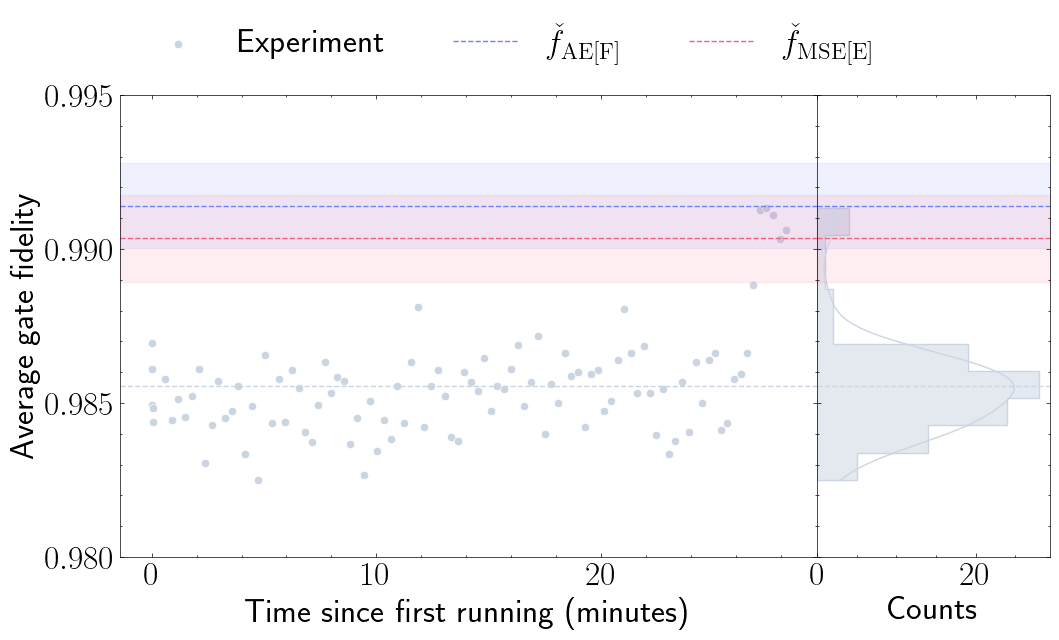

In [ ]:
with plt.style.context("science"):
    theta_name = "MAEF"
    fig, axes = plot_benchmark_result(
        model_data, theta_name=theta_name, y_limit=y_limit, font_size=font_size
    )
    plot_prediction_and_error_bar(
        axes,
        model_name="MAEF",
        theta_name=theta_name,
        model_data=model_data,
        fontsize=font_size,
    )
    plot_prediction_and_error_bar(
        axes,
        model_name="MSEE",
        theta_name=theta_name,
        model_data=model_data,
        fontsize=font_size,
    )

    # axes[0].legend(fontsize=font_size, loc='lower center', ncols=3)
    ax = axes[0]
    assert isinstance(ax, Axes)
    handles, legends = ax.get_legend_handles_labels()
    fig.legend(
        handles,
        legends,
        loc="upper center",
        bbox_to_anchor=(0.45, 1.05),
        fontsize=font_size,
        ncol=3,
    )
    fig.savefig("figure_6_AEF_benchmarking.pdf")

    # Plot the pulse
    control_fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    loaded_data.pulse_sequence.draw(
        model_data[theta_name]["pulse_params"], ax=ax, font_size=font_size
    )

    control_fig.savefig("figure_6_AEF_model_control.pdf")

fig

Experimental AGF of theta predicted by MSEE
Mean: 0.9913977777777777, Std: 0.0007373964912006755


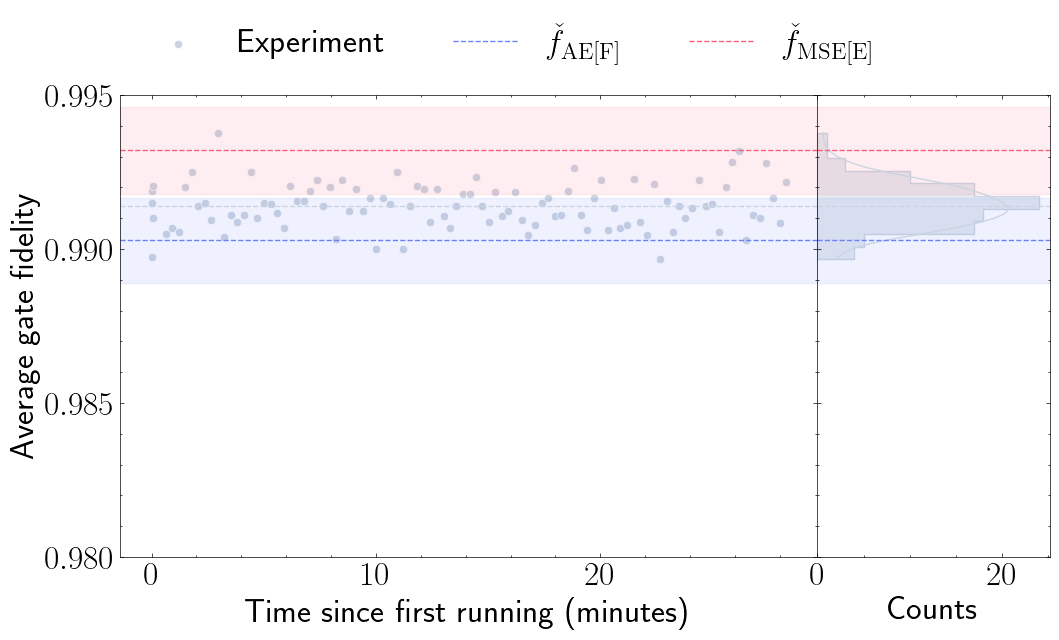

In [125]:
with plt.style.context("science"):
    theta_name = "MSEE"
    fig, axes = plot_benchmark_result(
        model_data, theta_name=theta_name, y_limit=y_limit, font_size=font_size
    )
    plot_prediction_and_error_bar(
        axes,
        model_name="MAEF",
        theta_name=theta_name,
        model_data=model_data,
        fontsize=font_size,
    )
    plot_prediction_and_error_bar(
        axes,
        model_name="MSEE",
        theta_name=theta_name,
        model_data=model_data,
        fontsize=font_size,
    )
    ax = axes[0]
    assert isinstance(ax, Axes)
    handles, legends = ax.get_legend_handles_labels()
    fig.legend(
        handles,
        legends,
        loc="upper center",
        bbox_to_anchor=(0.45, 1.05),
        fontsize=font_size,
        ncol=3,
    )

    fig.savefig("figure_6_MSEE_benchmarking.pdf")

    control_fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    loaded_data.pulse_sequence.draw(
        model_data[theta_name]["pulse_params"], ax=ax, font_size=font_size
    )

    control_fig.savefig('figure_6_MSEE_model_control.pdf')
fig

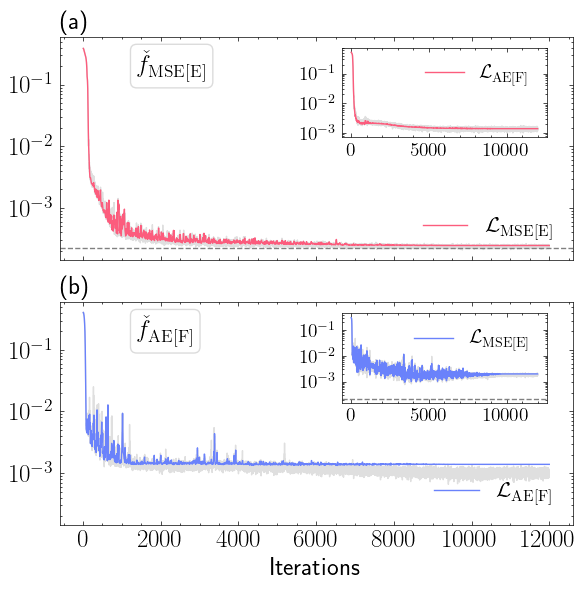

In [65]:
with plt.style.context("science"):
    fontsize = 18
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)
    plot_model_performance_v3(axes[0], "MSEE", model_data, 2 / (3 * shots), fontsize)
    plot_model_performance_v3(axes[1], "MAEF", model_data, 2 / (3 * shots), fontsize)
    fig.subplots_adjust(hspace=0.05)
    axes[1].set_xlabel("Iterations", fontsize=fontsize)
    axes[0].set_title("(a)", fontsize=fontsize, loc="left")
    axes[1].set_title("(b)", fontsize=fontsize, loc="left")
    fig.tight_layout()
    fig.savefig("figure_5_training.pdf")
fig

In [57]:
with plt.style.context("science"):
    fontsize = 18
    for model_name in model_names:
        fig, axes = plt.subplots(1, 1, figsize=(6, 3), sharex=True, sharey=True)
        plot_model_performance_v3(
            axes,
            model_name,
            model_data,
            2 / (3 * shots),
            fontsize,
            # x_ticklabels=True if model_name == "MAEF" else False,
            x_ticklabels=True
        )
        # fig.subplots_adjust(hspace=0.05)
        # if model_name == "MAEF":
        axes.set_xlabel("Iterations", fontsize=fontsize)
        fig.tight_layout()
        fig.savefig(f"figure_5_{model_name}_training.pdf")
